In [1]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("japan_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

head(jp_data)

Warning message:
: package 'forecast' was built under R version 3.2.5Loading required package: zoo
Warning message:
: package 'zoo' was built under R version 3.2.5
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
Warning message:
: package 'timeDate' was built under R version 3.2.3This is forecast 7.1 

Warning message:
: package 'car' was built under R version 3.2.5Warning message:
: package 'ggplot2' was built under R version 3.2.5Warning message:
: package 'scales' was built under R version 3.2.5

,Date,Value,Month
1,2002-01-01,67.70215,01
2,2002-02-01,67.55654,02
3,2002-03-01,67.91463,03
4,2002-04-01,68.32146,04
5,2002-05-01,68.32711,05
6,2002-06-01,68.58675,06


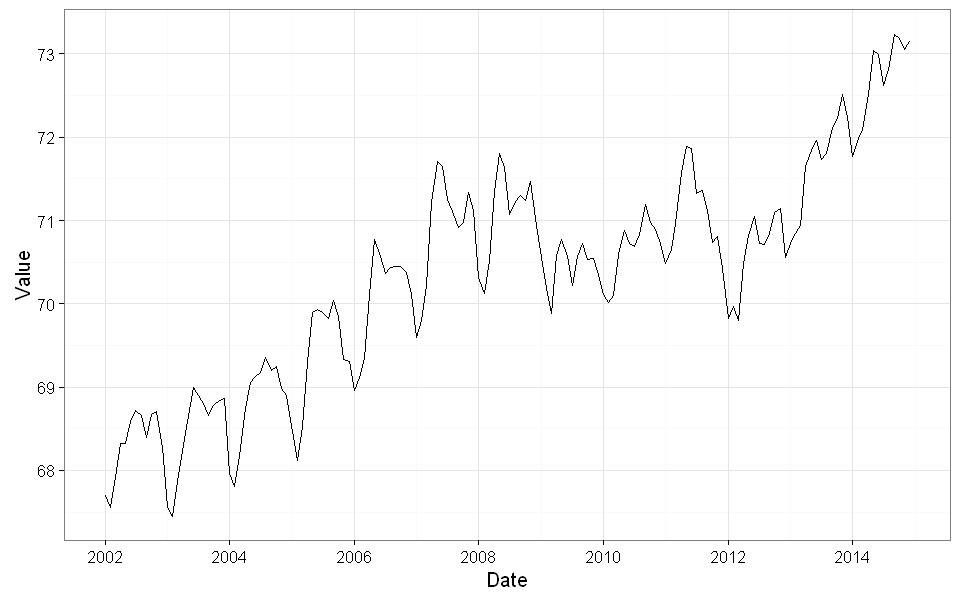

In [2]:
ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = Value)) +
    theme_bw()

Ej stationär, diffa trend (1)

Warning message:
: Removed 1 rows containing missing values (geom_path).

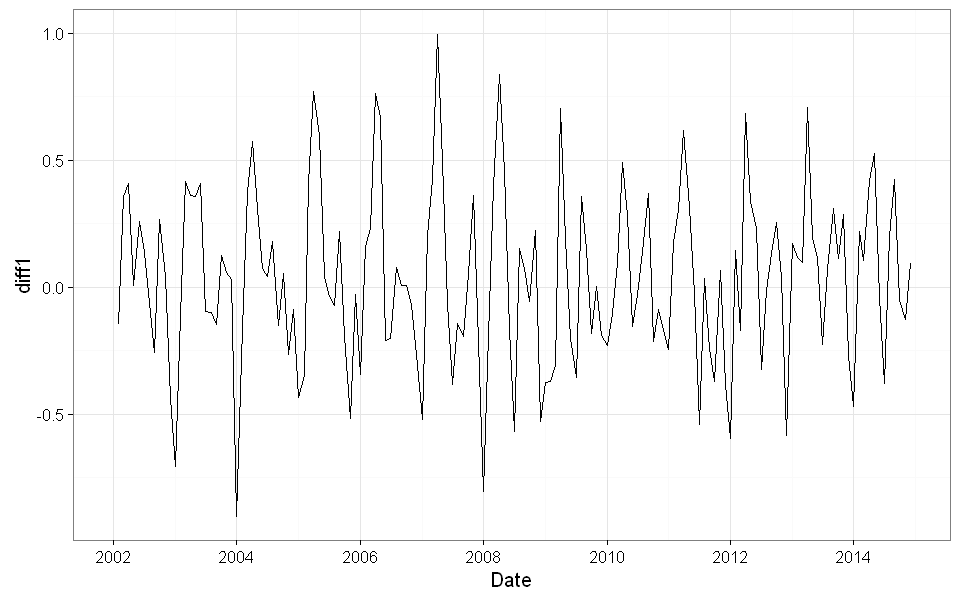

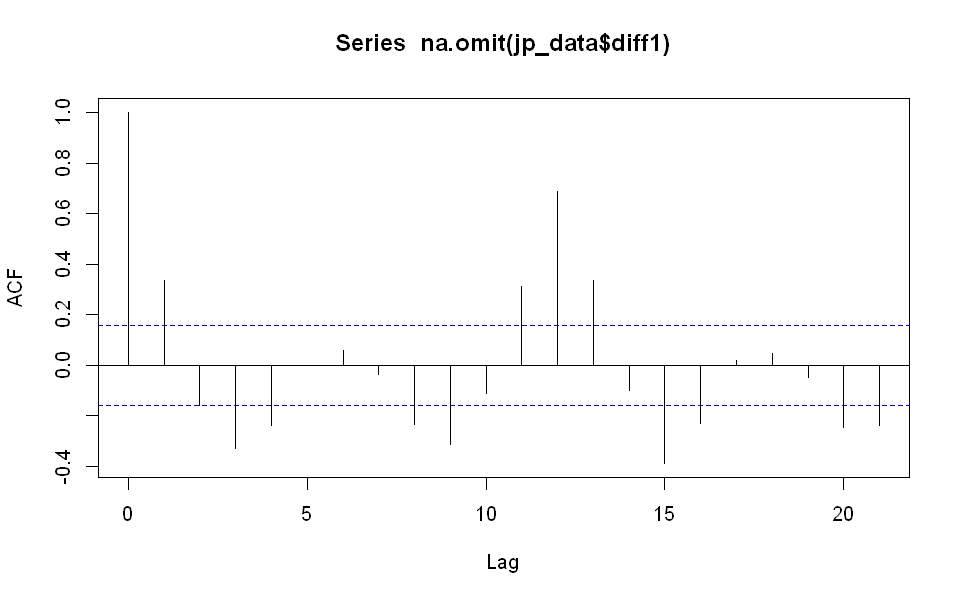

In [32]:
#help(diff)
diff1 <- diff(jp_data$Value, lag = 1)
jp_data$diff1 <- c(NA, diff1)

ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = diff1)) +
    theme_bw()

acf(na.omit(jp_data$diff1))

Ej stationär, diffa säsong (12)

Warning message:
: Removed 13 rows containing missing values (geom_path).

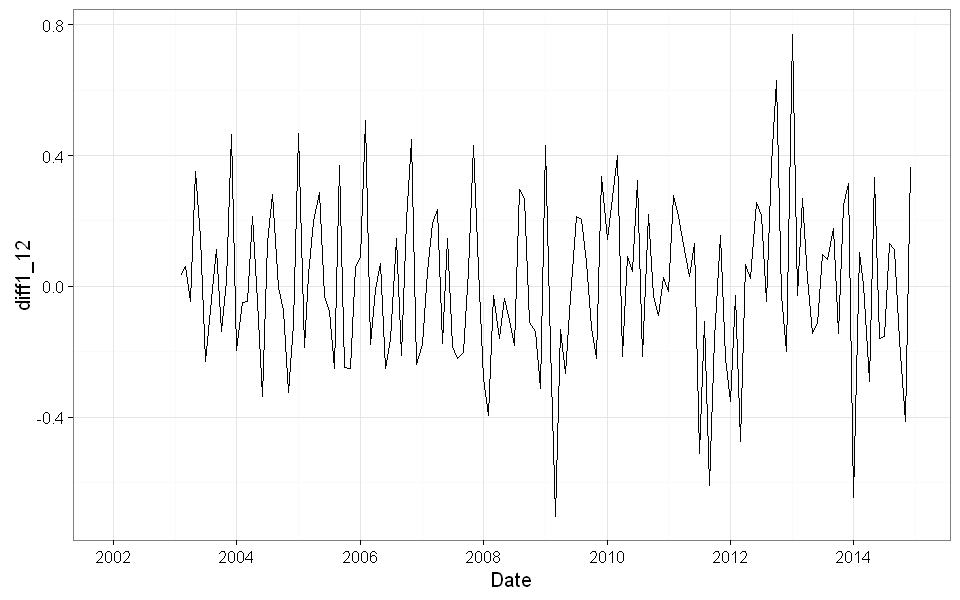

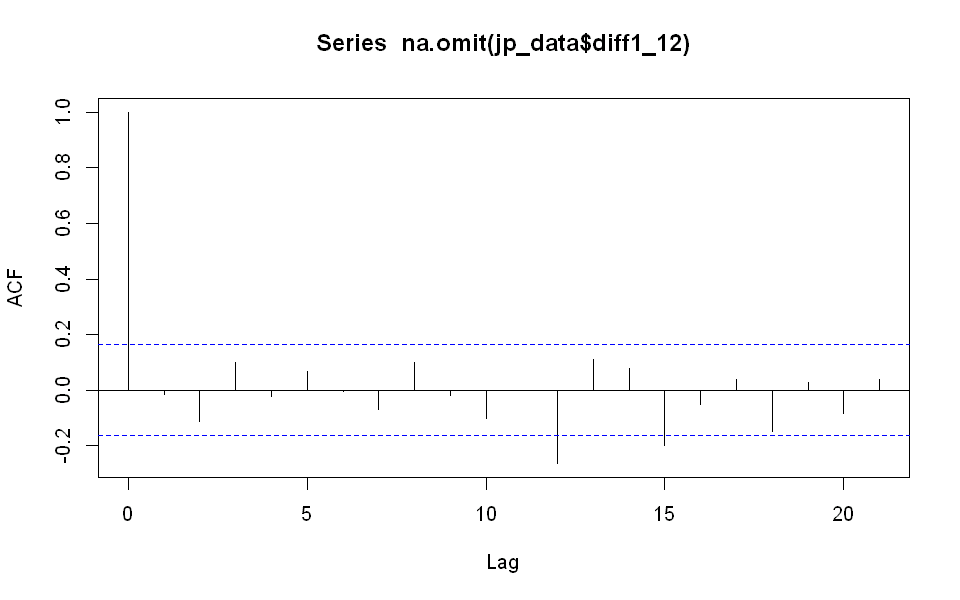

In [34]:
#help(diff)
diff1_12 <- diff(jp_data$diff1, lag = 12)
jp_data$diff1_12 <- c(rep(NA, 12), diff1_12)

ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = diff1_12)) +
    theme_bw()

acf(na.omit(jp_data$diff1_12))

Stationär ishhh?


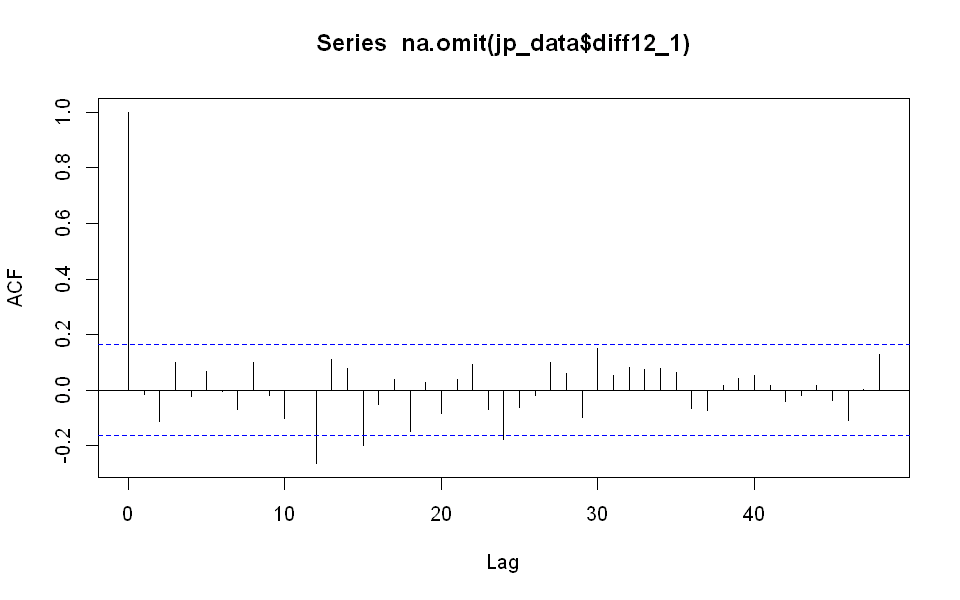

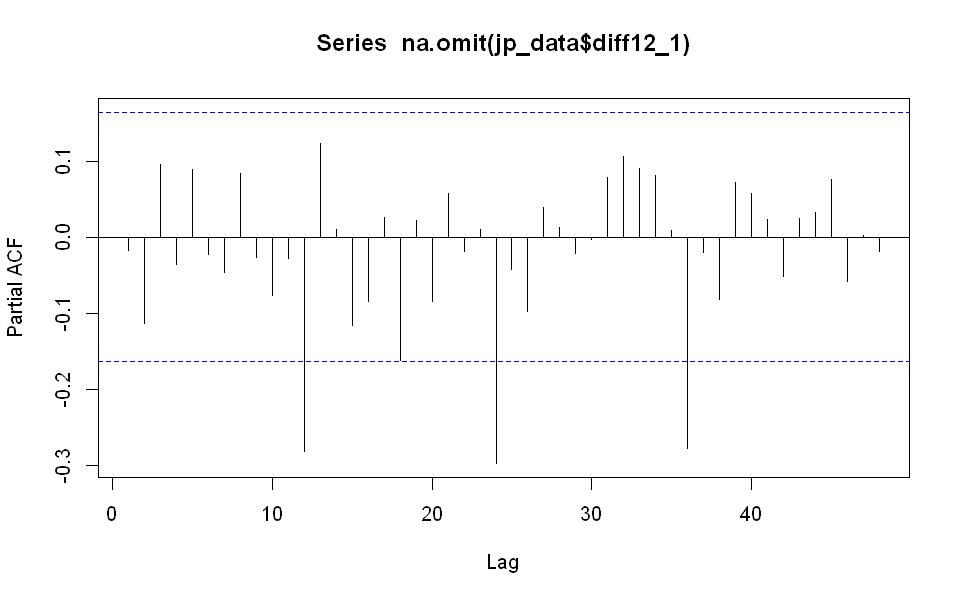

In [36]:
#help(acf)
acf(na.omit(jp_data$diff12_1), lag.max = 48)
pacf(na.omit(jp_data$diff12_1), lag.max = 48)

SARIMA(0,1,0)(3,1,0)

Series: jp_data$Value 
ARIMA(0,1,0)                    

sigma^2 estimated as 0.1167:  log likelihood=-53.41
AIC=108.82   AICc=108.84   BIC=111.86

Training set error measures:
                     ME      RMSE       MAE        MPE      MAPE      MASE
Training set 0.03536796 0.3404594 0.2693159 0.04909309 0.3832033 0.9951934
                  ACF1
Training set 0.3353458



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 173.05, df = 8, p-value < 0.00000000000000022



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 322.19, df = 20, p-value < 0.00000000000000022



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 447.28, df = 32, p-value < 0.00000000000000022


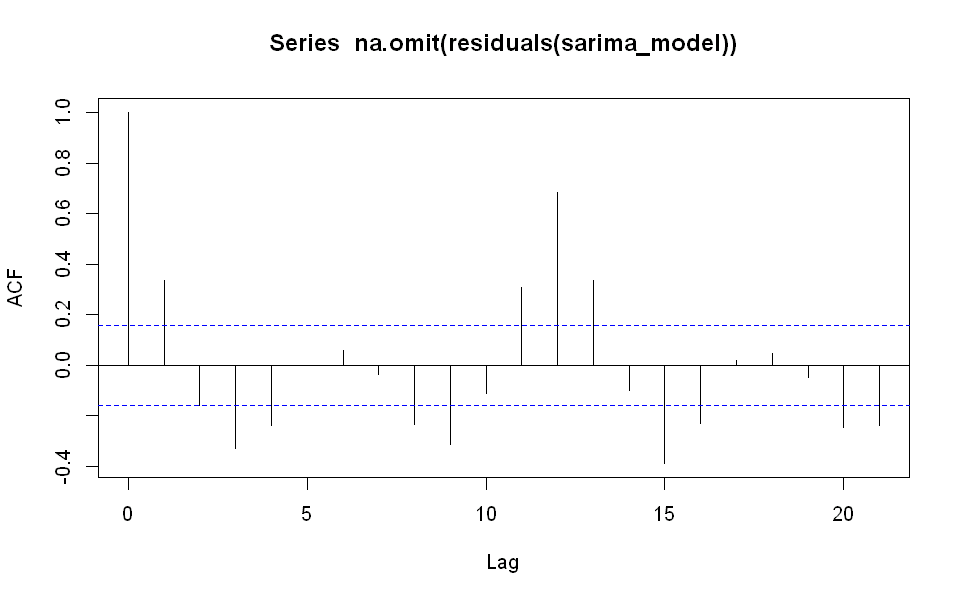

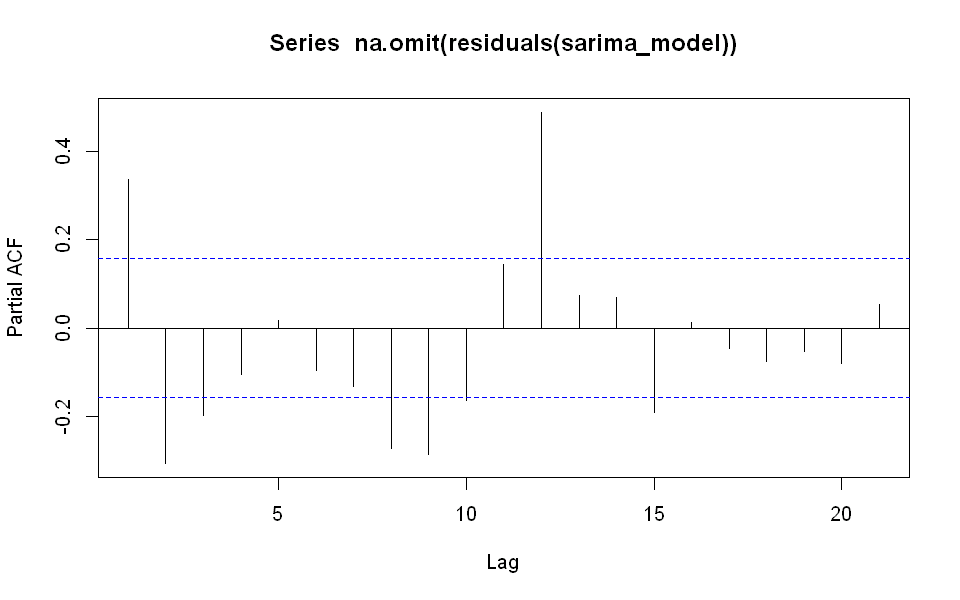

In [40]:
sarima_model <- Arima(jp_data$Value, order = c(0,1,0), seasonal = c(3,1,0))

summary(sarima_model)
Box.test(na.omit(residuals(sarima_model)), lag=12, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=24, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=36, fitdf=4, type="Ljung")

acf(na.omit(residuals(sarima_model)))
pacf(na.omit(residuals(sarima_model)))